<a href="https://colab.research.google.com/github/HilbertN/Analisis_de_datos_Tareas/blob/main/Tarea4_RedesNeuronales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models,regularizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Activation,MaxPooling2D,Flatten,Conv2D
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.losses import CategoricalCrossentropy,MeanSquaredError
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import  image
import pandas as pd 
import numpy as np
import shutil 
import os
import matplotlib.pyplot as plt

In [97]:
# Weights & Biases  (optional)
!pip install -q wandb

In [98]:
!wandb login

wandb: ERROR Find detailed error logs at: /content/wandb/debug-cli.root.log
Error: Connection to wandb service failed: [Errno 111] Connection refused. 


In [113]:
#Ejercicio 1: Entrena una red neuronal para que reproduzca la siguientes funciones en el  intervalo  de  [-1,1].  
# Graficar  la  solución  de  la  red  en  conjunto  con  la gráfica de la función.(a)  3 sin(πx)(b)  1 + 2x+ 4x3

#Ejercicio 1(a): 
#Vamos a proponer los siguientes arreglos como conjuntos de entranmiento y de prueba 

x_train = np.linspace(-1, 1, 1000).reshape(-1, 1)
y_train = 3 * np.sin(np.pi * x_train)

#Eliminamos elementos repetidos entre el conjunto de entrenamiento y de prueba
v=np.linspace(-1, 1, 100)
cond=np.isin(np.linspace(-1, 1, 100),np.linspace(-1, 1, 1000))
v=v[np.where(~cond)]

x_test = v.reshape(-1, 1)
y_test= 3 * np.sin(np.pi * x_test)


In [114]:
#No hay elementos repetidos entre el conjunto de prueba y entrenamiento
h1=set(np.linspace(-1, 1, 1000))
h3=set(v)
Repetidos=list(h3.intersection(h1))
Repetidos

[]

In [115]:
model = Sequential()
model.add(Dense(300, activation='relu', input_shape=(1,)))
model.add(Dropout(0.2))
model.add(Dense(300, activation='relu'))
model.add(Dense(1))




In [116]:
batch_size=30 
epochs=40 
learning_rate=0.03
Optimizador=SGD

In [117]:
model.compile(loss='mean_squared_error', optimizer=Optimizador(learning_rate=learning_rate), metrics=['mse'])
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_test, y_test))

Epoch 1/40
34/34 [==============================] - 1s 15ms/step - loss: 2.1939 - mse: 2.1939 - val_loss: 1.1548 - val_mse: 1.1548
Epoch 2/40
34/34 [==============================] - 0s 5ms/step - loss: 1.0931 - mse: 1.0931 - val_loss: 0.9586 - val_mse: 0.9586
Epoch 3/40
34/34 [==============================] - 0s 5ms/step - loss: 0.9854 - mse: 0.9854 - val_loss: 0.8724 - val_mse: 0.8724
Epoch 4/40
34/34 [==============================] - 0s 5ms/step - loss: 0.8873 - mse: 0.8873 - val_loss: 0.8608 - val_mse: 0.8608
Epoch 5/40
34/34 [==============================] - 0s 5ms/step - loss: 0.7824 - mse: 0.7824 - val_loss: 0.6429 - val_mse: 0.6429
Epoch 6/40
34/34 [==============================] - 0s 5ms/step - loss: 0.6347 - mse: 0.6347 - val_loss: 0.6204 - val_mse: 0.6204
Epoch 7/40
34/34 [==============================] - 0s 5ms/step - loss: 0.4991 - mse: 0.4991 - val_loss: 0.3429 - val_mse: 0.3429
Epoch 8/40
34/34 [==============================] - 0s 5ms/step - loss: 0.3598 - mse: 0.3

4/4 [==============================] - 0s 5ms/step


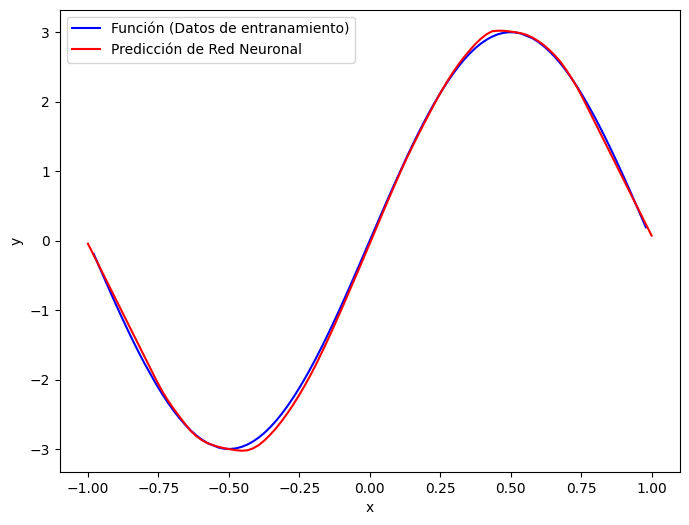

In [120]:
x_pred = np.linspace(-1, 1, 100).reshape(-1, 1)
y_pred = model.predict(x_pred)


plt.figure(figsize=(8, 6))
plt.plot(x_test, y_test, color='blue', label='Función (Datos de entranamiento)')
plt.plot(x_pred, y_pred, color='red', label='Predicción de Red Neuronal')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

plt.show()

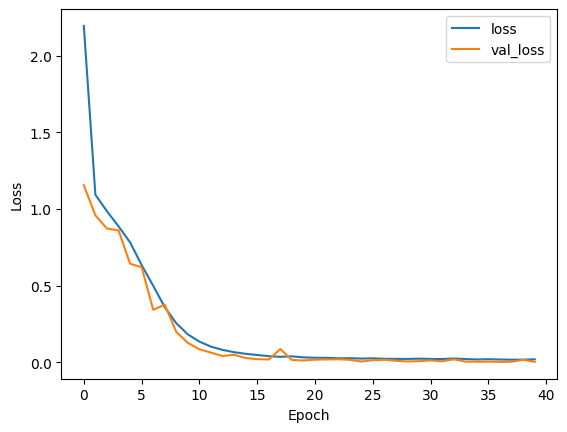

In [119]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(loss, label='loss')
plt.plot(val_loss, label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()



In [137]:
#Ejercicio 1(b): 
#Vamos a proponer los siguientes arreglos como conjuntos de entranmiento y de prueba 

x_train = np.linspace(-1, 1, 10000).reshape(-1, 1)
y_train = 1+2*x_train+4*np.power(x_train,3.)

#Eliminamos elementos repetidos entre el conjunto de entrenamiento y de prueba
v=np.linspace(-1, 1, 100)
cond=np.isin(np.linspace(-1, 1, 100),np.linspace(-1, 1, 1000))
v=v[np.where(~cond)]

x_test = v.reshape(-1, 1)
y_test = 1+2*x_test+4*np.power(x_test,3.)


In [122]:
model = Sequential()
model.add(Dense(600, activation='relu', input_shape=(1,)))
model.add(Dropout(0.2))
model.add(Dense(600, activation='relu'))
model.add(Dense(1))



In [146]:
model = Sequential()
model.add(Dense(800, activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=(1,)))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(200, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(300, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(1))

In [107]:
model = Sequential()
model.add(Dense(600, activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=(1,)))
model.add(Dropout(0.2))
model.add(Dense(1))

In [147]:
batch_size=120
epochs=30
learning_rate=0.01
Optimizador=SGD


In [148]:
model.compile(loss='mean_squared_error', optimizer=SGD(learning_rate=learning_rate), metrics=['mse'])
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_test, y_test))

Epoch 1/30
84/84 [==============================] - 3s 21ms/step - loss: 12.0927 - mse: 6.6380 - val_loss: 11.2351 - val_mse: 5.8597
Epoch 2/30
84/84 [==============================] - 1s 18ms/step - loss: 7.6988 - mse: 2.3675 - val_loss: 6.3668 - val_mse: 1.1022
Epoch 3/30
84/84 [==============================] - 1s 17ms/step - loss: 6.1355 - mse: 0.9551 - val_loss: 5.8058 - val_mse: 0.7102
Epoch 4/30
84/84 [==============================] - 1s 11ms/step - loss: 6.0364 - mse: 1.0197 - val_loss: 6.6300 - val_mse: 1.6979
Epoch 5/30
84/84 [==============================] - 1s 11ms/step - loss: 6.1165 - mse: 1.2587 - val_loss: 5.1006 - val_mse: 0.3202
Epoch 6/30
84/84 [==============================] - 1s 11ms/step - loss: 5.4111 - mse: 0.7045 - val_loss: 5.0326 - val_mse: 0.4030
Epoch 7/30
84/84 [==============================] - 1s 11ms/step - loss: 5.3108 - mse: 0.7515 - val_loss: 4.9273 - val_mse: 0.4409
Epoch 8/30
84/84 [==============================] - 1s 11ms/step - loss: 5.0821 -

4/4 [==============================] - 0s 4ms/step


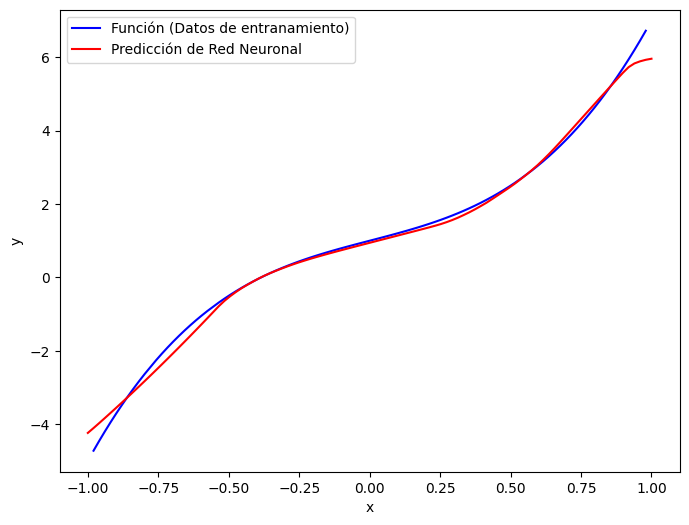

In [149]:
x_pred = np.linspace(-1, 1, 100).reshape(-1, 1)
y_pred = model.predict(x_pred)

plt.figure(figsize=(8, 6))
plt.plot(x_test, y_test, color='blue', label='Función (Datos de entranamiento)')
plt.plot(x_pred, y_pred, color='red', label='Predicción de Red Neuronal')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

plt.show()

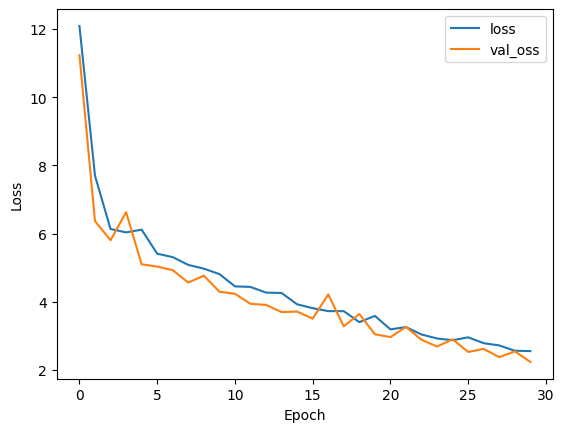

In [150]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(loss, label='loss')
plt.plot(val_loss, label='val_oss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
#Ejercicio dos: Identificar enfermedades en plantas 


In [ ]:
#Para leer datos desde Google Drive: 
from google.colab import drive 
drive.mount('/content/drive') 

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Base de datos/train.csv', names=['Nombre', 'Clase'])

In [ ]:
df=df.drop(0,axis=0)#Eliminamos la primera fila que no es d eutilidad

In [ ]:
df.Clase.unique()#Checamos las etiquetas de las clases

In [ ]:
df[df['Clase']=='healthy']['Nombre'].size

In [ ]:
for x in list(df.Clase.unique()): 
  y=df[df['Clase']==x]['Nombre'].size
  print(f'{x}={y}')

In [ ]:
df.shape

In [ ]:
#Vamos a mezclar de manera aleatoria todas las filas del csv
#df= df.sample(frac=1, random_state=42)
#Vamos a dividir a la mitad la base de datos para la primera parte para imagenes de entrenamiento y la otra por prueba
#df1=df.iloc[0:9316,:]
#df2=df.iloc[9316:18633,:]

In [ ]:
#Podemos notar que los conjuntos no tienen elementos en común 
#set(df1.Nombre).intersection(set(df2.Nombre))

In [ ]:
# Ruta de la carpeta de destino para las subcarpetas
mini_train = '/content/train_'

# Crear la carpeta de destino si no existe
if not os.path.exists(mini_train ):
    os.makedirs(mini_train )

In [ ]:
#Formamos una lista ordenada de las categorias de que tenemos en nuestro csv
E= df.sort_values('Clase')
clases= list(E.Clase.unique())

In [ ]:
#El próposito de este for es formar carpetas de cada una de las clasificaciones en la carpeta llamada train_
#Cada carpeta consta de 50 imágenes con la finalidad de reducir el tiempo de aprendizaje de la red convolucional
for i in clases:
    contador = 0  # Contador de imágenes en la carpeta actual
    for c in list(df[df['Clase'] == i]['Nombre']):
        if contador >= 50:
            break  # Se alcanzó el límite de imágenes por carpeta
        imagen= os.path.join('/content/drive/MyDrive/Base de datos/train_images', c)
        if os.path.exists(imagen):
            mt= os.path.join(mini_train , 'train_' + i)
            if not os.path.exists(mt):
                os.makedirs(mt)
            m= shutil.copy(imagen,mt)
            contador+= 1



In [ ]:
l=list(os.listdir('/content/train_'))


In [ ]:
#Realizamos el mismo procedimiento para crear la carpeta con subcarpetas de las categorías del problema
#Esta vez para el conjunto de prueba 

# Ruta de la carpeta de destino para las subcarpetas
mini_test = '/content/test_'

# Crear la carpeta de destino si no existe
if not os.path.exists(mini_test):
    os.makedirs(mini_test )

In [ ]:
#Formamos una lista ordenada de las categorias de que tenemos en nuestro csv
#E= df2.sort_values('Clase')
#clases= list(E.Clase.unique())

In [ ]:
#El próposito de este for es formar carpetas de cada una de las clasificaciones en la carpeta llamada test_
#Cada carpeta consta de 5 imágenes,estamos considerado el 10% de las imagenes de entrenamiento.
for i in clases:
    contador = 0  # Contador de imágenes en la carpeta actual
    for c in list(df[df['Clase'] == i]['Nombre']):
        if contador >= 5:
            break  # Se alcanzó el límite de imágenes por carpeta
        imagen= os.path.join('/content/drive/MyDrive/Base de datos/train_images', c)
        if os.path.exists(imagen):
            mt= os.path.join(mini_test , 'test_' + i)
            if not os.path.exists(mt):
                os.makedirs(mt)
            m= shutil.copy(imagen,mt)
            contador+= 1


In [ ]:
ih,iw=150,150 #Tamaño de la imagen
input_shape=(ih,iw,3) #forma de la imagen : Largo, Ancho y colores
train_dir= '/content/train_' #directorio de entrenamiento
test_dir='/content/test_' #directorio de prueba 
num_class=12 #Número de clases
epochs=30 #Epocas
batch_size=5  #batch para hacer cada entrenamiento. Lee 5 'batch_size' imagenes antes de actualizar
num_train= 600 #Número de imágenes en train 
num_test=60 #Número de imágenes en test
epoch_steps= num_train//batch_size 
test_steps=num_test//batch_size

In [ ]:
h1=set(os.listdir(train_dir))
h2=set(os.listdir(test_dir))
l=h1.intersection(h2)
l

In [ ]:
gentrain = ImageDataGenerator(rescale=1. / 255., rotation_range=20,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.2,zoom_range=0.2) 
#Generamos más imágenes mediante rotaciones y traslaciones 

train = gentrain.flow_from_directory(train_dir,
                batch_size=batch_size,
                target_size=(iw, ih),
                class_mode='categorical',shuffle=True )

gentest = ImageDataGenerator(rescale=1. / 255)

test = gentest.flow_from_directory(test_dir,
                batch_size=batch_size,
                target_size=(iw, ih),
                class_mode='categorical',shuffle=True )

In [ ]:
#shutil.rmtree('/content/train_') #Para eliminar una carpeta


In [ ]:
#shutil.rmtree('/content/test_') #Para eliminar una carpeta

In [ ]:
model=Sequential() 
model.add(Conv2D(10,(3,3),input_shape=(ih,iw,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(10,(3,3))) 
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2))) 

model.add(Conv2D(20,(3,3))) 
model.add(Activation('relu')) 
model.add(MaxPooling2D(pool_size=(2,2))) 

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(64)) 
model.add(Activation('relu')) 
model.add(Dropout(0.2))
model.add(Dense(12)) 
model.add(Activation('softmax'))



In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(ih, iw, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(12))
model.add(Activation('softmax'))

In [ ]:
import wandb
from wandb.keras import WandbCallback
wandb.init(project="Red_Neuronal_Ejercicio1b")
wandb.config.learning_rate = 0.001
wandb.config.epochs = epochs
wandb.config.steps_per_epoch =epoch_steps
wandb.config.optimizador=RMSprop
wandb.config.validation_steps=test_steps

In [ ]:
loss= CategoricalCrossentropy()
model.compile(loss=loss, optimizer=RMSprop(learning_rate=0.001), metrics=['accuracy'])
model.fit(train, steps_per_epoch=epoch_steps, epochs=epochs, validation_data=test, validation_steps=test_steps,callbacks=[WandbCallback()])